In [1]:
import torch
from ast import literal_eval
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_columns', None)

In [2]:
# Load the train dataset
# TODO Train Data 경로 입력
dataset = pd.read_csv('../data/train.csv') 

# Flatten the JSON dataset
records = []
for _, row in dataset.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', None),
        "question_plus": problems.get('question_plus', None),
    }
    # Include 'question_plus' if it exists
    if 'question_plus' in problems:
        record['question_plus'] = problems['question_plus']
    records.append(record)
        
# Convert to DataFrame
df = pd.DataFrame(records)

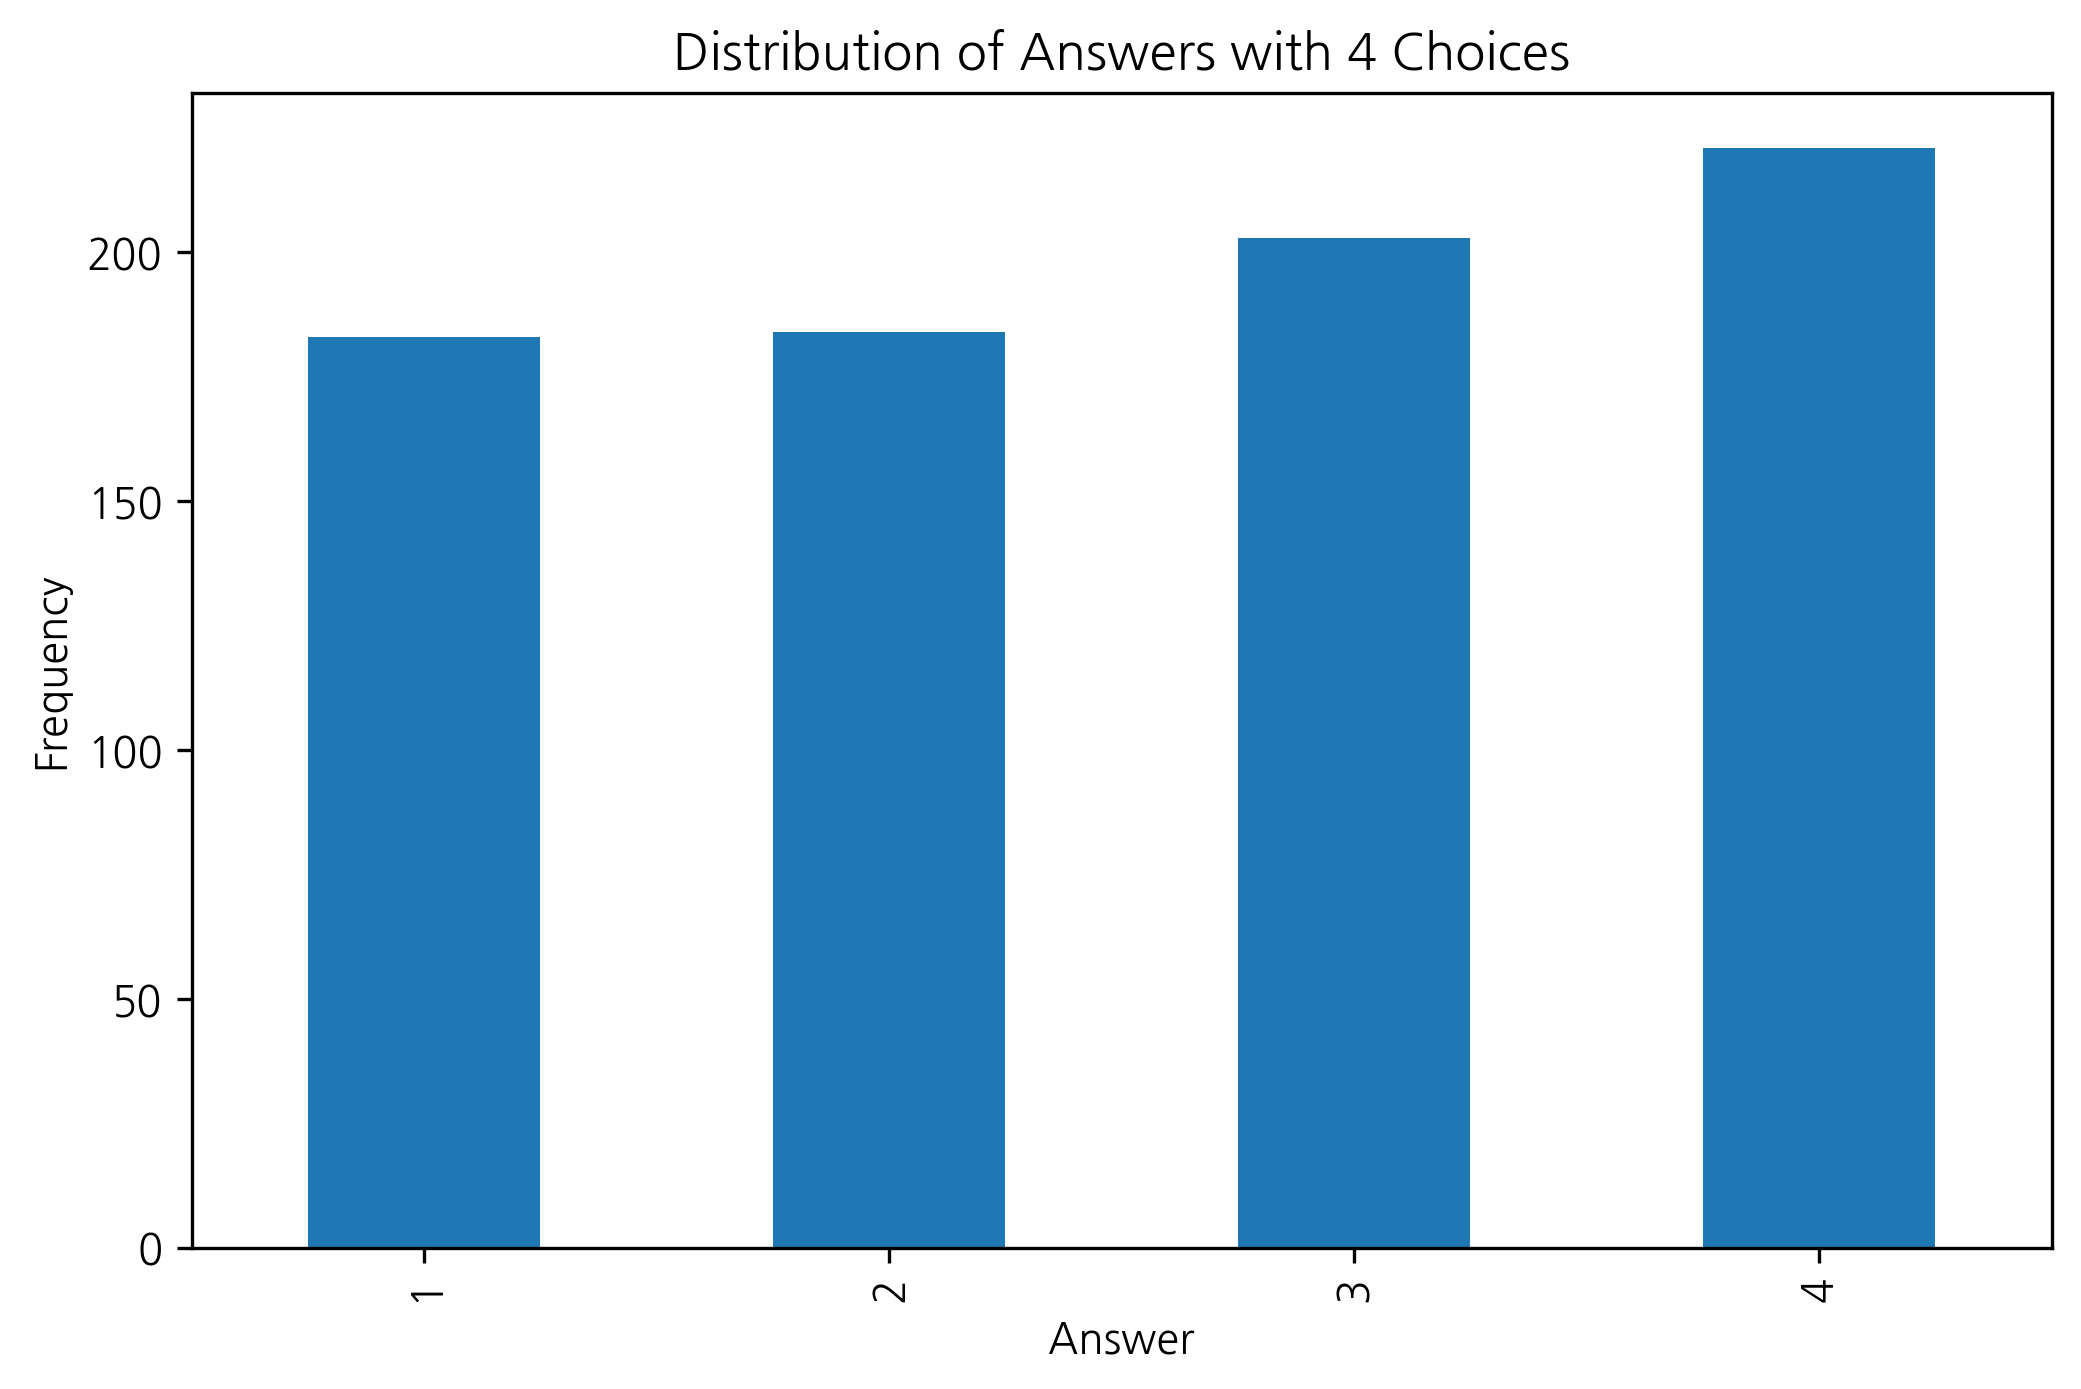

In [3]:
# Filter the dataframe to include only rows where the length of 'choices' is 4
df_4_choices = df[df['choices'].apply(lambda x: len(x) == 4)]

# Count the distribution of 'answer'
answer_distribution = df_4_choices['answer'].value_counts().sort_index()

# Plot the distribution
answer_distribution.plot(kind='bar')
plt.xlabel('Answer')
plt.ylabel('Frequency')
plt.title('Distribution of Answers with 4 Choices')
plt.show()

answer
1    765
2    265
3    116
4     62
5     31
Name: count, dtype: int64 
total number of questions with 5 choices:  1239


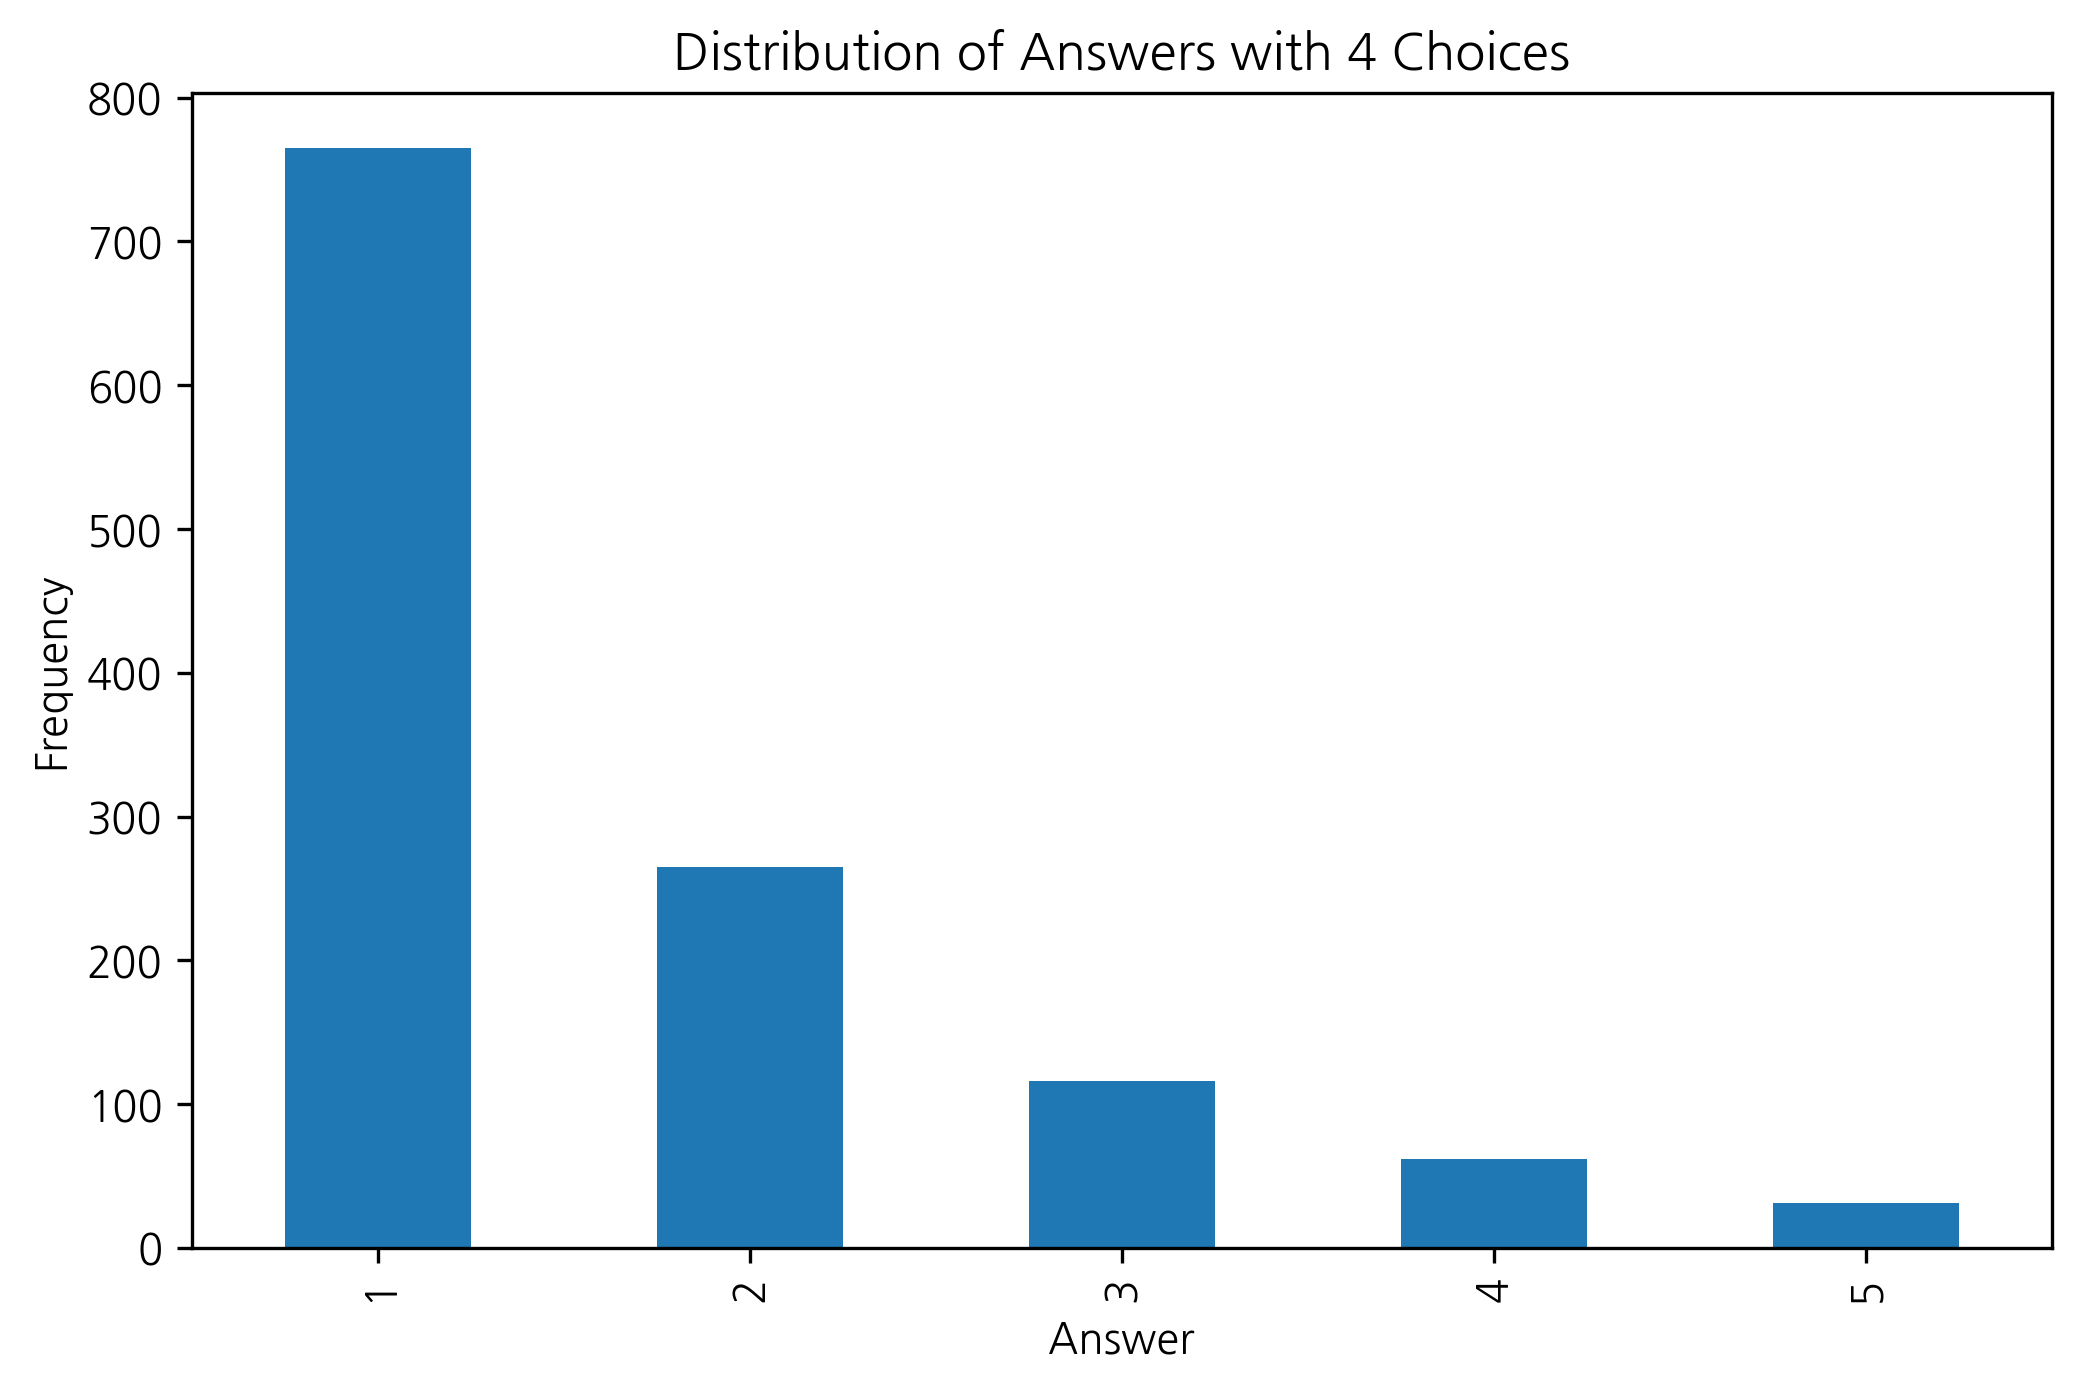

In [4]:
# Filter the dataframe to include only rows where the length of 'choices' is 5
df_5_choices = df[df['choices'].apply(lambda x: len(x) == 5)]

# Count the distribution of 'answer'
answer_distribution = df_5_choices['answer'].value_counts().sort_index()

# number of questions with 5 choices
print(answer_distribution, "\ntotal number of questions with 5 choices: ", str(answer_distribution.sum()))

# Plot the distribution
answer_distribution.plot(kind='bar')
plt.xlabel('Answer')
plt.ylabel('Frequency')
plt.title('Distribution of Answers with 4 Choices')
plt.show()

In [5]:
# 랜덤 시드 고정
random.seed(42)
np.random.seed(42)

# 5개의 선택지가 있는 문항만 필터링
df_5_choices = df[df['choices'].apply(len) == 5].copy()

# 전체 문항 수 계산
total_questions = len(df_5_choices)

# 각 답변당 할당될 문항 수 계산
questions_per_answer = total_questions // 5
remainder = total_questions % 5

# 각 답변별 목표 개수 설정 (1부터 5까지)
target_distribution = {
    i: questions_per_answer + (1 if i <= remainder else 0)
    for i in range(1, 6)
}

# 현재 답변 분포 확인
current_distribution = df_5_choices['answer'].value_counts().sort_index()
print("\n원본 분포:")
print(current_distribution)

# 새로운 데이터프레임 생성
balanced_df = df_5_choices.copy()

def rotate_choices(choices_list, old_answer, new_answer):
    """
    정답을 새로운 위치로 이동하고 나머지 선택지들의 상대적 순서를 유지합니다.
    """
    if old_answer == new_answer:
        return choices_list
    
    # 정답 선택지를 저장
    correct_answer = choices_list[old_answer - 1]
    
    # 정답을 제외한 나머지 선택지들
    other_choices = choices_list[:old_answer - 1] + choices_list[old_answer:]
    
    # 새로운 위치에 정답을 삽입
    result = other_choices[:new_answer - 1] + [correct_answer] + other_choices[new_answer - 1:]
    
    return result

# 각 답변에 대해 목표 개수만큼 할당
for new_answer in range(1, 6):
    target_count = target_distribution[new_answer]
    # 아직 처리되지 않은 문항 중에서 선택
    available_indices = balanced_df[~balanced_df['processed']].index if 'processed' in balanced_df.columns else balanced_df.index
    selected_indices = np.random.choice(available_indices, min(target_count, len(available_indices)), replace=False)
    
    for idx in selected_indices:
        old_answer = balanced_df.loc[idx, 'answer']
        # choices 리스트 회전
        balanced_df.at[idx, 'choices'] = rotate_choices(
            balanced_df.loc[idx, 'choices'],
            old_answer,
            new_answer
        )
        # 새로운 답변 할당
        balanced_df.at[idx, 'answer'] = new_answer
    
    # 처리된 문항 표시
    if 'processed' not in balanced_df.columns:
        balanced_df['processed'] = False
    balanced_df.loc[selected_indices, 'processed'] = True

# 'processed' 컬럼 제거
balanced_df = balanced_df.drop('processed', axis=1)

# 결과 확인
new_distribution = balanced_df['answer'].value_counts().sort_index()
print("\n균형잡힌 분포:")
print(new_distribution)
print("\n총 문항 수:", len(balanced_df))

# 예시로 몇 개의 변경된 문항 출력
print("\n변경 예시 (처음 1개 문항):")
for idx in balanced_df.index[:5]:
    print(f"\n문항 {idx}:")
    print(f"질문: {balanced_df.loc[idx, 'question']}")
    print(f"선택지:")
    for i, choice in enumerate(balanced_df.loc[idx, 'choices'], 1):
        print(f"{i}. {choice}")
    print(f"정답: {balanced_df.loc[idx, 'answer']}")


원본 분포:
answer
1    765
2    265
3    116
4     62
5     31
Name: count, dtype: int64

균형잡힌 분포:
answer
1    248
2    248
3    248
4    248
5    247
Name: count, dtype: int64

총 문항 수: 1239

변경 예시 (처음 1개 문항):

문항 791:
질문: 부산정보산업진흥원이 지원하는 2020~2021년 지역SW서비스사업화 지원사업의 주관 부처는 무엇인가?
선택지:
1. 부산광역시
2. 중소벤처기업부
3. 과학기술정보통신부
4. 산업통상자원부
5. 교육부
정답: 3

문항 792:
질문: 조세심판원 상임심판관으로 임명된 J과장은 어떤 부서의 과장직을 맡고 있었던가?
선택지:
1. 국세청
2. 행정자치부
3. 지방세분석과
4. 재정경제부
5. 세무서
정답: 3

문항 793:
질문: 토즈 스터디센터의 ‘겨울, 실력을 만들다’ 캠페인에서 제공하는 혜택 중 하나는 무엇인가?
선택지:
1. 3개월 무료 이용권
2. 고급독서대와 스터디플래너
3. 장학금 100만원
4. 스터디센터 1년 무료 이용권
5. 1인당 400만원 상당의 아이비리그 투어
정답: 5

문항 794:
질문: ‘그랜드 키친 홈다이닝 투고’의 판매 기간은 언제부터 언제까지인가?
선택지:
1. 1월 1일부터 3월 1일까지
2. 12월 1일부터 1월 31일까지
3. 12월 21일부터 1월 15일까지
4. 1월 15일부터 2월 28일까지
5. 12월 21일부터 2월 28일까지
정답: 5

문항 795:
질문: 콘트래리언의 정의는 무엇인가?
선택지:
1. 모두가 동의하는 방향으로 행동하는 사람
2. 남들과는 반대 방향으로 도전하는 사람
3. 위험을 감수하지 않는 사람
4. 주택시장에 투자하는 사람
5. 성공을 추구하는 일반적인 사람
정답: 2


In [6]:
def verify_answer_consistency(original_df, balanced_df):
    """
    원본 데이터프레임과 균형 조정된 데이터프레임의 정답이 일치하는지 검증합니다.
    """
    mismatched_count = 0
    print("\n정답 일치 여부 검증:")
    
    for idx in original_df.index:
        original_choices = original_df.loc[idx, 'choices']
        original_answer = original_df.loc[idx, 'answer']
        original_answer_text = original_choices[original_answer - 1]
        
        balanced_choices = balanced_df.loc[idx, 'choices']
        balanced_answer = balanced_df.loc[idx, 'answer']
        balanced_answer_text = balanced_choices[balanced_answer - 1]
        
        # 정답 텍스트가 일치하는지 확인
        if original_answer_text != balanced_answer_text:
            mismatched_count += 1
            print(f"\n불일치 발견 - 문항 {idx}:")
            print(f"원본 질문: {original_df.loc[idx, 'question']}")
            print(f"원본 선택지: {original_choices}")
            print(f"원본 정답 번호: {original_answer}")
            print(f"원본 정답 텍스트: {original_answer_text}")
            print(f"변경된 선택지: {balanced_choices}")
            print(f"변경된 정답 번호: {balanced_answer}")
            print(f"변경된 정답 텍스트: {balanced_answer_text}")
    
    # 검증 결과 요약
    total_questions = len(original_df)
    match_count = total_questions - mismatched_count
    
    print(f"\n검증 결과 요약:")
    print(f"전체 문항 수: {total_questions}")
    print(f"일치하는 문항 수: {match_count}")
    print(f"불일치하는 문항 수: {mismatched_count}")
    print(f"정답 일치율: {(match_count/total_questions)*100:.2f}%")
    
    return mismatched_count == 0

# 검증 실행
is_valid = verify_answer_consistency(df_5_choices, balanced_df)
if is_valid:
    print("\n검증 성공: 모든 문항의 정답이 일치합니다.")
else:
    print("\n검증 실패: 일부 문항의 정답이 불일치합니다.")


정답 일치 여부 검증:

검증 결과 요약:
전체 문항 수: 1239
일치하는 문항 수: 1239
불일치하는 문항 수: 0
정답 일치율: 100.00%

검증 성공: 모든 문항의 정답이 일치합니다.


In [7]:
# concatenate the balanced dataset with the 4-choice dataset
final_df = pd.concat([balanced_df, df_4_choices], ignore_index=True)

# save the final dataset
# TODO 경로 입력
final_df.to_csv('../data/train_balanced.csv', index=False)